In [13]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
#file_path = '/Users/fabianschweisthal/Documents/Uni/2. Semester/PBL/Dataset/ccs/ccs_data.csv'
file_path = 'final_data.csv'
data = pd.read_csv(file_path, sep=',')


In [14]:
# Select relevant columns and rename them for consistency
# data = data.rename(columns={
#     'NumRotatableBonds': 'num_rotatable_bonds',
#     'FractionSP3': 'fraction_sp3',
#     'Length': 'molecule_length'
# # })
# data = data[['Sequence', 'Charge', 'CCS', 'num_rotatable_bonds', 'fraction_sp3', 'molecule_length']]


In [15]:
# Define the 20 standard amino acids and include non-standard ones
amino_acids = 'ACDEFGHIKLMNPQRSTVWYU'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

def one_hot_encode(seq, max_length):
    # Pad the sequence to the maximum length with 'X' (unknown amino acid)
    padded_seq = seq.ljust(max_length, 'X')
    int_encoded = [aa_to_int.get(aa, len(amino_acids)) for aa in padded_seq]  # Use a default index for unknown amino acids
    one_hot_encoded = np.zeros((max_length, len(amino_acids) + 1))  # +1 for the unknown amino acid
    for i, value in enumerate(int_encoded):
        one_hot_encoded[i, value] = 1
    return one_hot_encoded.flatten()

In [16]:
# Determine the maximum sequence length
max_seq_length = max(data['Sequence'].apply(len))

# Encode the sequences
one_hot_encoded_sequences = np.array([one_hot_encode(seq, max_seq_length) for seq in data['Sequence']])

# Initialize the label encoder for charge states
label_encoder = LabelEncoder()
encoded_charge_states = label_encoder.fit_transform(data['Charge'].tolist())

In [17]:
# Calculate additional features
sequence_lengths = data['Sequence'].apply(len).values.reshape(-1, 1)

def calculate_composition(seq, amino_acids):
    count = Counter(seq)
    return [count[aa] for aa in amino_acids]

amino_acid_composition = np.array([calculate_composition(seq, amino_acids) for seq in data['Sequence']])

# Combine all features
# encoded_features = np.hstack((
#     one_hot_encoded_sequences,
#     encoded_charge_states.reshape(-1, 1),
#     sequence_lengths,
#     amino_acid_composition,
#     data[['num_rotatable_bonds', 'fraction_sp3', 'molecule_length']].values
# ))
encoded_features = np.hstack((
    one_hot_encoded_sequences,
    encoded_charge_states.reshape(-1, 1),
    sequence_lengths,
    amino_acid_composition
))


In [ ]:

# Define the target variable
ccs_values = data['CCS'].values

# # Normalize the CCS values
# scaler = MinMaxScaler()
# normalized_ccs_values = scaler.fit_transform(ccs_values.reshape(-1,1)).flatten()

#use an alternative method to normalize the CCS values
normalized_ccs_values = (ccs_values - ccs_values.min()) / (ccs_values.max() - ccs_values.min())


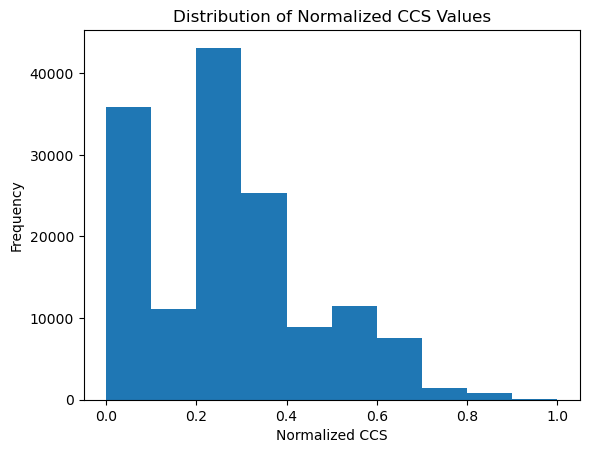

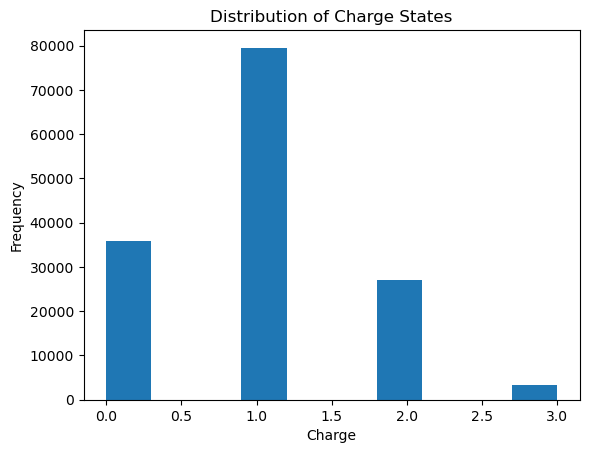

In [34]:
# show distribution of normalized_ccs_values in a plot
import matplotlib.pyplot as plt
plt.hist(normalized_ccs_values)
plt.xlabel('Normalized CCS')
plt.ylabel('Frequency')
plt.title('Distribution of Normalized CCS Values')
plt.show()

#show distribution of Charge within the data
plt.hist(encoded_charge_states)
plt.xlabel('Charge')
plt.ylabel('Frequency')
plt.title('Distribution of Charge States')
plt.show()






In [19]:
# Train-Test Split with random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(encoded_features, normalized_ccs_values, test_size=0.2, random_state=42)


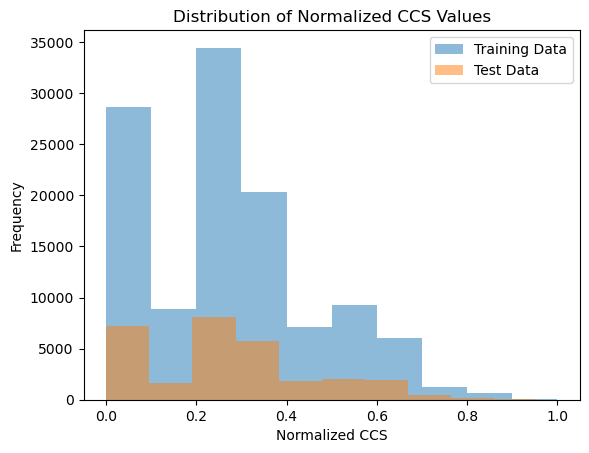

In [37]:
#show distribution of the value Charge in the training data compared to the training data
plt.hist(y_train, alpha=0.5, label='Training Data')
plt.hist(y_test, alpha=0.5, label='Test Data')
plt.xlabel('Normalized CCS')
plt.ylabel('Frequency')
plt.title('Distribution of Normalized CCS Values')
plt.legend()




In [20]:
# Train the Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [21]:
# Evaluate the Model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Mean Squared Error: 0.00036954216859912966
R² Score: 0.9901877905472967


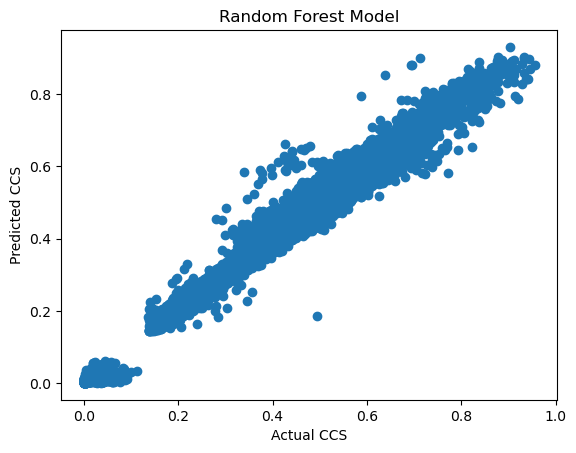

In [31]:
#plot the results of the model evaluation and use a scale to show the correlation between the predicted and actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual CCS')
plt.ylabel('Predicted CCS')
plt.title('Random Forest Model')
plt.show()






In [23]:

# Check the variance of the features
print("Variance of features:")
print(np.var(encoded_features, axis=0))

# Check the distribution of the target variable
print("Distribution of target variable (CCS values):")
print(pd.Series(ccs_values).describe())

# Check the first few rows of the features and target variable
print("First few rows of features:")
print(encoded_features[:5])
print("First few rows of target variable:")
print(ccs_values[:5])


Variance of features:
[7.14984007e-02 1.44613281e-02 5.94804937e-02 ... 1.46306726e-01
 3.92716945e-01 4.80068346e-05]
Distribution of target variable (CCS values):
count    1.458090e+05
mean     1.651661e-35
std      7.959930e-36
min      5.557483e-36
25%      1.175582e-35
50%      1.628201e-35
75%      2.034124e-35
max      4.648568e-35
dtype: float64
First few rows of features:
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]]
First few rows of target variable:
[2.65404611e-35 5.99001956e-36 1.20833720e-35 2.19943848e-35
 1.19978297e-35]


In [40]:
# make a model that trains for each charge state separately

# Split the data into charge states
charge_states = np.unique(data['Charge'])
X_train_split = {}
X_test_split = {}
y_train_split = {}
y_test_split = {}
for charge in charge_states:
    indices = np.where(data['Charge'] == charge)[0]
    X_train_split[charge], X_test_split[charge], y_train_split[charge], y_test_split[charge] = train_test_split(encoded_features[indices], normalized_ccs_values[indices], test_size=0.2, random_state=42)
    
# Train the Random Forest Model for each charge state
models = {}
for charge in charge_states:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_split[charge], y_train_split[charge])
    models[charge] = model
    
# Evaluate the Model for each charge state
mse_split = {}
r2_split = {}
for charge in charge_states:
    y_pred = models[charge].predict(X_test_split[charge])
    mse_split[charge] = mean_squared_error(y_test_split[charge], y_pred)
    r2_split[charge] = r2_score(y_test_split[charge], y_pred)
    
print("Mean Squared Error for each charge state:")
print(mse_split)
print("R² Score for each charge state:")
print(r2_split)




Mean Squared Error for each charge state:
{1: 4.1758553262485565e-05, 2: 0.00013086084047066464, 3: 0.001120080579263347, 4: 0.003411814059003029}
R² Score for each charge state:
{1: 0.6489272458942564, 2: 0.9645574139985515, 3: 0.837102181438919, 4: 0.6825565336830326}
